Testing Nonlinear Kalman Filters for IMU Data
Generating nonlinear test data...
<class 'dict'>
Running filters...

Results:
EKF Position RMSE: 2.0331
EKF Acceleration RMSE: 0.3571

Recommendations:
1. For moderate nonlinearity: Use EKF (faster, good performance)
2. For severe nonlinearity: Use UKF (better accuracy)
3. For STM32: Start with EKF due to computational constraints
4. Tune Q and R matrices based on your specific sensor characteristics


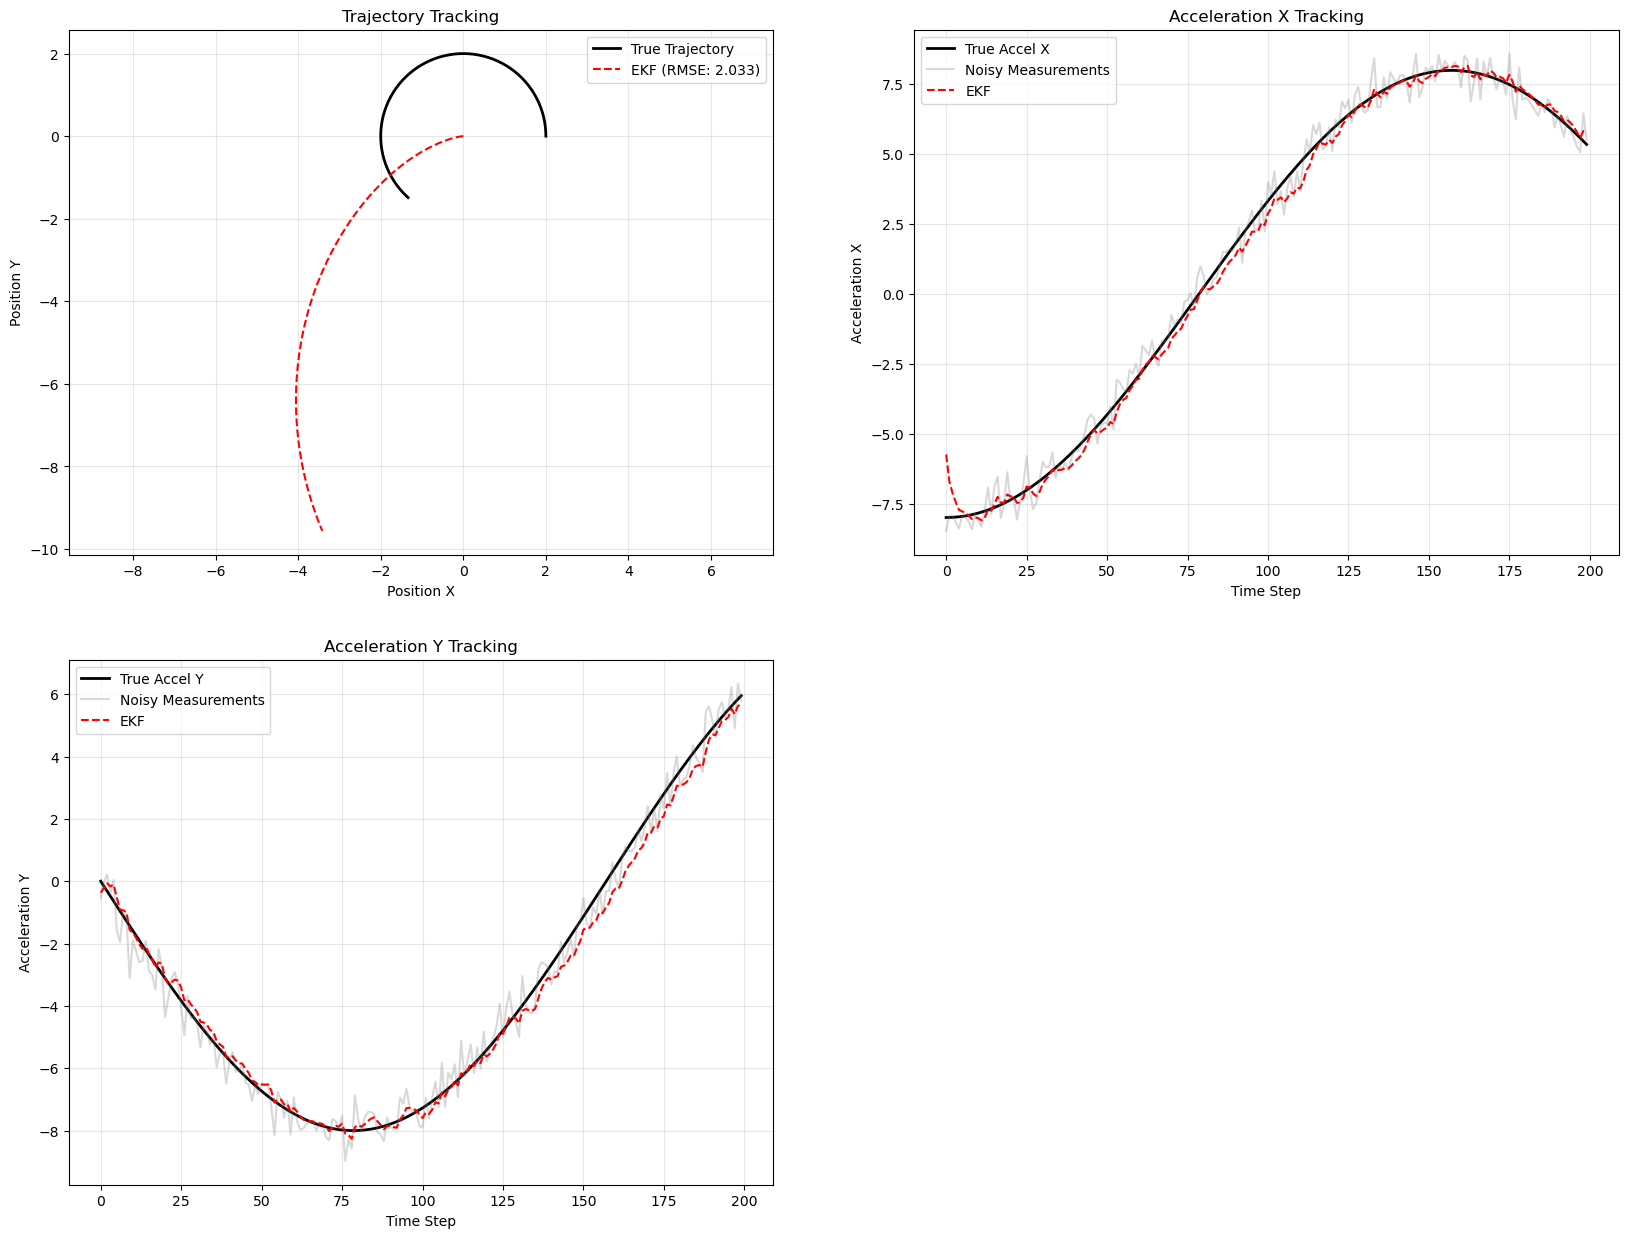

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from math import sin, cos, sqrt, atan2

class ExtendedKalmanFilter:
    """
    Extended Kalman Filter for nonlinear acceleration tracking
    State: [position_x, position_y, velocity_x, velocity_y, accel_x, accel_y]
    """
    def __init__(self, dt=0.01):
        self.dt = dt
        self.n_states = 3  # [pos_x, pos_y, vel_x, vel_y, accel_x, accel_y]
        
        # Initial state [pos_x, pos_y, vel_x, vel_y, accel_x, accel_y]
        self.x = np.zeros(self.n_states)
        
        # Initial covariance matrix
        self.P = np.eye(self.n_states) * 1.0
        
        # Process noise covariance
        self.Q = np.diag([0.1, 0.05, 0.05])
        
        # Measurement noise covariance (for acceleration measurements)
        self.R = np.eye(2) * 0.5  # 2x2 for accel_x, accel_y measurements
        
    def state_transition(self, x, u=None):
        """
        Nonlinear state transition function
        x[k+1] = f(x[k], u[k])
        """
        dt = self.dt
        
        # Extract states
        pos_x, pos_y, vel_x, vel_y, accel_x, accel_y = x
        
        # Nonlinear motion model with acceleration
        new_pos_x = pos_x + vel_x * dt + 0.5 * accel_x * dt**2
        new_pos_y = pos_y + vel_y * dt + 0.5 * accel_y * dt**2
        new_vel_x = vel_x + accel_x * dt
        new_vel_y = vel_y + accel_y * dt
        
        # Acceleration can change (process noise will handle uncertainty)
        new_accel_x = accel_x
        new_accel_y = accel_y
        
        return np.array([new_pos_x, new_pos_y, new_vel_x, new_vel_y, new_accel_x, new_accel_y])
    
    def jacobian_F(self, x):
        """
        Jacobian of state transition function
        """
        dt = self.dt
        F = np.array([
            [1, 0, dt, 0,  0.5*dt**2, 0],
            [0, 1, 0,  dt, 0,         0.5*dt**2],
            [0, 0, 1,  0,  dt,        0],
            [0, 0, 0,  1,  0,         dt],
            [0, 0, 0,  0,  1,         0],
            [0, 0, 0,  0,  0,         1]
        ])
        return F
    
    def measurement_function(self, x):
        """
        Measurement function h(x)
        We measure acceleration directly
        """
        return np.array([x[4], x[5]])  # accel_x, accel_y
    
    def jacobian_H(self, x):
        """
        Jacobian of measurement function
        """
        H = np.array([
            [0, 0, 0, 0, 1, 0],  # accel_x measurement
            [0, 0, 0, 0, 0, 1]   # accel_y measurement
        ])
        return H
    
    def predict(self):
        """
        Prediction step
        """
        # Predict state
        self.x = self.state_transition(self.x)
        F = self.jacobian_F(self.x)
        self.P = F @ self.P @ F.T + self.Q
    
    def update(self, z):
        """
        Update step
        z: measurement vector [accel_x, accel_y]
        """
        # Predicted measurement
        h = self.measurement_function(self.x)
        
        # Innovation
        y = z - h
        
        # Innovation covariance
        H = self.jacobian_H(self.x)
        S = H @ self.P @ H.T + self.R
        
        # Kalman gain
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # Update state
        self.x = self.x + K @ y
        
        # Update covariance
        I = np.eye(self.n_states)
        self.P = (I - K @ H) @ self.P
        
        return self.x


# Test and comparison functions
def generate_nonlinear_data(n_samples=200):
    """
    Generate test data with nonlinear acceleration patterns
    """
    dt = 0.01
    time = np.arange(0, n_samples * dt, dt)
    
    # Circular motion - highly nonlinear acceleration
    radius = 2.0
    omega = 2.0  # rad/s
    
    # True states
    angles = omega * time
    positions_x = radius * np.cos(angles)
    positions_y = radius * np.sin(angles)
    
    velocities_x = -radius * omega * np.sin(angles)
    velocities_y = radius * omega * np.cos(angles)
    
    # Nonlinear acceleration (centripetal)
    accels_x = -radius * omega**2 * np.cos(angles)
    accels_y = -radius * omega**2 * np.sin(angles)
    
    # Add noise to acceleration measurements
    noise_std = 0.5
    noisy_accels_x = accels_x + np.random.normal(0, noise_std, len(accels_x))
    noisy_accels_y = accels_y + np.random.normal(0, noise_std, len(accels_y))
    
    true_data = {
        'time': time,
        'pos_x': positions_x,
        'pos_y': positions_y,
        'vel_x': velocities_x,
        'vel_y': velocities_y,
        'accel_x': accels_x,
        'accel_y': accels_y
    }
    
    measurements = {
        'accel_x': noisy_accels_x,
        'accel_y': noisy_accels_y
    }
    
    return true_data, measurements

def test_nonlinear_filters():
    """
    Test and compare EKF vs UKF performance
    """
    print("Generating nonlinear test data...")
    true_data, measurements = generate_nonlinear_data(200)
    print(type(measurements))
    
    # Initialize filters
    ekf = ExtendedKalmanFilter(dt=0.01)
    
    # Storage for results
    ekf_results = {'pos_x': [], 'pos_y': [], 'accel_x': [], 'accel_y': []}
    
    print("Running filters...")
    for i in range(len(measurements['accel_x'])):
        z = np.array([measurements['accel_x'][i], measurements['accel_y'][i]])
        
        # EKF
        ekf.predict()
        ekf_state = ekf.update(z)
        ekf_results['pos_x'].append(ekf_state[0])
        ekf_results['pos_y'].append(ekf_state[1])
        ekf_results['accel_x'].append(ekf_state[4])
        ekf_results['accel_y'].append(ekf_state[5])
        
    
    # Calculate RMSE
    def calc_rmse(est, true):
        return np.sqrt(np.mean((np.array(est) - np.array(true))**2))
    
    ekf_pos_rmse = calc_rmse(ekf_results['pos_x'], true_data['pos_x'])
    ekf_accel_rmse = calc_rmse(ekf_results['accel_x'], true_data['accel_x'])
    
    print(f"\nResults:")
    print(f"EKF Position RMSE: {ekf_pos_rmse:.4f}")
    print(f"EKF Acceleration RMSE: {ekf_accel_rmse:.4f}")
    
    # Plot results
    plt.figure(figsize=(20, 15))
    
    # Trajectory comparison
    plt.subplot(2, 2, 1)
    plt.plot(true_data['pos_x'], true_data['pos_y'], 'k-', label='True Trajectory', linewidth=2)
    plt.plot(ekf_results['pos_x'], ekf_results['pos_y'], 'r--', label=f'EKF (RMSE: {ekf_pos_rmse:.3f})', linewidth=1.5)
    plt.xlabel('Position X')
    plt.ylabel('Position Y')
    plt.title('Trajectory Tracking')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    
    # Acceleration X
    plt.subplot(2, 2, 2)
    time_steps = range(len(true_data['accel_x']))
    plt.plot(time_steps, true_data['accel_x'], 'k-', label='True Accel X', linewidth=2)
    plt.plot(time_steps, measurements['accel_x'], 'gray', alpha=0.3, label='Noisy Measurements')
    plt.plot(time_steps, ekf_results['accel_x'], 'r--', label='EKF', linewidth=1.5)
    plt.xlabel('Time Step')
    plt.ylabel('Acceleration X')
    plt.title('Acceleration X Tracking')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Acceleration Y
    plt.subplot(2, 2, 3)
    plt.plot(time_steps, true_data['accel_y'], 'k-', label='True Accel Y', linewidth=2)
    plt.plot(time_steps, measurements['accel_y'], 'gray', alpha=0.3, label='Noisy Measurements')
    plt.plot(time_steps, ekf_results['accel_y'], 'r--', label='EKF', linewidth=1.5)
    plt.xlabel('Time Step')
    plt.ylabel('Acceleration Y')
    plt.title('Acceleration Y Tracking')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
   

if __name__ == "__main__":
    print("Testing Nonlinear Kalman Filters for IMU Data")
    print("=" * 50)
    
    # Run the test
    ekf = test_nonlinear_filters()
    
    print("\n" + "=" * 50)
    print("Recommendations:")
    print("1. For moderate nonlinearity: Use EKF (faster, good performance)")
    print("2. For severe nonlinearity: Use UKF (better accuracy)")
    print("3. For STM32: Start with EKF due to computational constraints")
    print("4. Tune Q and R matrices based on your specific sensor characteristics")